In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pandas import DataFrame as df

In [2]:

file = open("RML2016.10a_dict.pkl",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

In [3]:
with open("RML2016.10a_dict.pkl",'rb') as file:
    Xd = pickle.load(file, encoding='bytes')

In [4]:
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [5]:
# Prepare data
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  
            lbl.append((mod,snr))
X = np.vstack(X)

In [6]:
# Create features
features = {}
features['raw'] = X[:,0], X[:,1]
features['derivative'] = (np.gradient(X[:,0], axis=1), np.gradient(X[:,1], axis=1))
features['integral'] = (np.cumsum(X[:,0], axis=1), np.cumsum(X[:,1], axis=1))

In [7]:
def extract_features(*arguments):
    desired = ()            
    for arg in arguments:
        desired += features[arg]
    return np.stack(desired, axis=1)

In [8]:
# Extract features and prepare labels
data = extract_features('raw')
y = np.array([x[0] for x in lbl])
snrs = np.array([x[1] for x in lbl]).astype(int)

In [9]:
# Split data
X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(
    data, y, snrs, test_size=0.3, random_state=10, stratify=y)

In [10]:
# Binarize labels
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)

c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated in v1.5 and will error in v1.7. Convert the labels to a string or integer format.
  warnings.warn(
c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\multiclass.py:367: FutureWarning: Support for labels represented as bytes is deprecated

In [11]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [12]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [13]:
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [14]:
# Define ANN model
class ANN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape[0] * input_shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.model(x)

In [15]:
class CNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ZeroPad2d((0, 2)),
            nn.Conv2d(1, 256, kernel_size=(1, 3)),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.conv2 = nn.Sequential(
            nn.ZeroPad2d((0, 2)),
            nn.Conv2d(256, 80, kernel_size=(2, 3)),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        # Corrected input size: 80 * 1 * 128 = 10240
        self.fc = nn.Sequential(
            nn.Linear(80 * 1 * 128, 256),  # Updated from 80 * (input_shape[0]-1) * (input_shape[1]-2)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [16]:
# Training function
def train_model(model, train_loader, test_loader, epochs, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')
        
        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [17]:
# Initialize models
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

ann_model = ANN(input_shape, num_classes)
cnn_model = CNN(input_shape, num_classes)

In [18]:
# Train ANN
print("Training ANN...")
ann_model = train_model(ann_model, train_loader, test_loader, epochs=100)
torch.save(ann_model.state_dict(), 'ann.pth')

Training ANN...
Epoch 1, Train Loss: 2.3819, Val Loss: 2.3540
Epoch 2, Train Loss: 2.3450, Val Loss: 2.3403
Epoch 3, Train Loss: 2.3379, Val Loss: 2.3375
Epoch 4, Train Loss: 2.3360, Val Loss: 2.3386
Epoch 5, Train Loss: 2.3355, Val Loss: 2.3363
Epoch 6, Train Loss: 2.3343, Val Loss: 2.3356
Epoch 7, Train Loss: 2.3331, Val Loss: 2.3338
Epoch 8, Train Loss: 2.3295, Val Loss: 2.3293
Epoch 9, Train Loss: 2.3217, Val Loss: 2.3201
Epoch 10, Train Loss: 2.3106, Val Loss: 2.3083


In [19]:
# Train CNN
print("\nTraining CNN...")
cnn_model = train_model(cnn_model, train_loader, test_loader, epochs=10)
torch.save(cnn_model.state_dict(), 'cnn.pth')


Training CNN...
Epoch 1, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 2, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 3, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 4, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 5, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 6, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 7, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 8, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 9, Train Loss: 2.3979, Val Loss: 2.3979
Epoch 10, Train Loss: 2.3979, Val Loss: 2.3979


In [20]:
# Evaluation functions
def plot_results(model, X_test, y_test, snr_test):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X_test))
        y_pred = outputs.numpy()
    
    sorted_snrs = np.sort(np.unique(snr_test))
    x_axis = []
    y_axis = []
    for snr in sorted_snrs:
        idx = np.where(snr_test == snr)
        x_axis.append(snr)
        y_axis.append(accuracy_score(np.argmax(y_test[idx], axis=1), 
                                np.argmax(y_pred[idx], axis=1)))
    
    plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
    plt.xlabel('SNR')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy over different SNRs')
    plt.grid(True)
    plt.show()

def print_results(model, X_test, y_test, snr_test):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X_test))
        y_pred = outputs.numpy()
    
    sorted_snrs = np.sort(np.unique(snr_test))
    results = []
    for snr in sorted_snrs:
        idx = np.where(snr_test == snr)
        acc = accuracy_score(np.argmax(y_test[idx], axis=1), 
                         np.argmax(y_pred[idx], axis=1))
        results.append(acc * 100)
    
    return df(data=[results], columns=sorted_snrs, index=['accuracy']).round(2)

def plot_confusion_matrix(model, X_test, y_test, classes):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X_test))
        y_pred = outputs.numpy()
    
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

# Load models (if needed)
# ann_model.load_state_dict(torch.load('ann.pth'))
# cnn_model.load_state_dict(torch.load('cnn.pth'))

In [22]:
def print_results(model, X_test, y_test, snr_test, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_pred.append(outputs.cpu().numpy())  # Move outputs to CPU for numpy conversion
    y_pred = np.concatenate(y_pred, axis=0)
    
    sorted_snrs = np.sort(np.unique(snr_test))
    results = []
    for snr in sorted_snrs:
        idx = np.where(snr_test == snr)
        acc = accuracy_score(np.argmax(y_test[idx], axis=1), 
                             np.argmax(y_pred[idx], axis=1))
        results.append(acc * 100)
    
    return df(data=[results], columns=sorted_snrs, index=['accuracy']).round(2)

In [23]:
def plot_results(model, X_test, y_test, snr_test, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_pred.append(outputs.cpu().numpy())  # Move outputs to CPU for numpy conversion
    y_pred = np.concatenate(y_pred, axis=0)
    
    sorted_snrs = np.sort(np.unique(snr_test))
    x_axis = []
    y_axis = []
    for snr in sorted_snrs:
        idx = np.where(snr_test == snr)
        x_axis.append(snr)
        y_axis.append(accuracy_score(np.argmax(y_test[idx], axis=1), 
                                    np.argmax(y_pred[idx], axis=1)))
    
    plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
    plt.xlabel('SNR')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy over different SNRs')
    plt.grid(True)
    plt.show()

In [24]:

def plot_confusion_matrix(model, X_test, y_test, classes, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_pred.append(outputs.cpu().numpy())  # Move outputs to CPU for numpy conversion
    y_pred = np.concatenate(y_pred, axis=0)
    
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(classes)),
           yticks=np.arange(len(classes)),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

In [25]:
# Evaluate CNN
print("\nCNN Results:")
print_results(cnn_model, X_test, y_test, snr_test, test_loader)


CNN Results:


,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,8.85,9.71,9.46,8.15,8.6,9.58,9.34,9.32,9.08,9.1,9.34,9.24,9.04,8.74,8.49,8.9,9.26,9.32,9.17,9.11


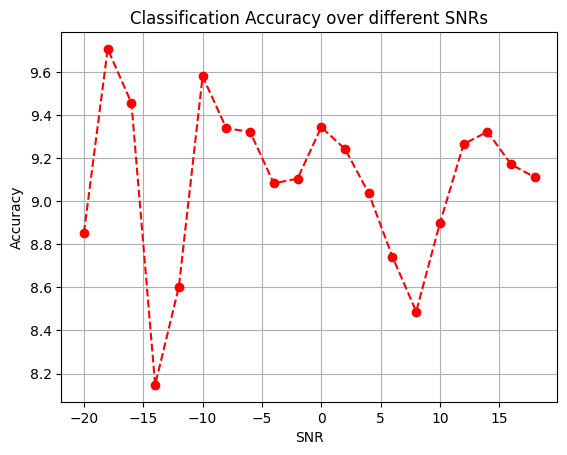

In [26]:
plot_results(cnn_model, X_test, y_test, snr_test, test_loader)

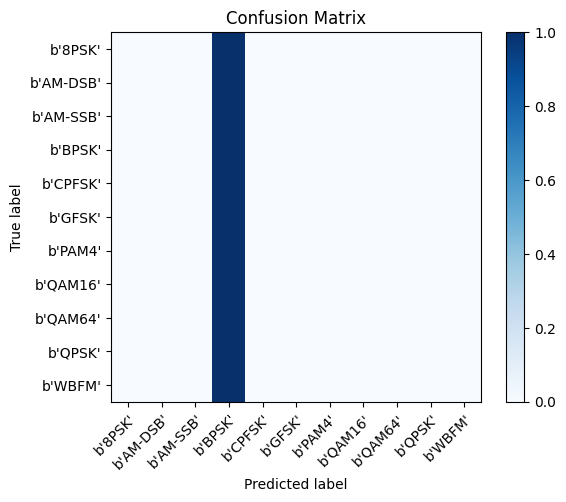

In [27]:
plot_confusion_matrix(cnn_model, X_test, y_test, mods, test_loader)


Evaluating both models...


c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


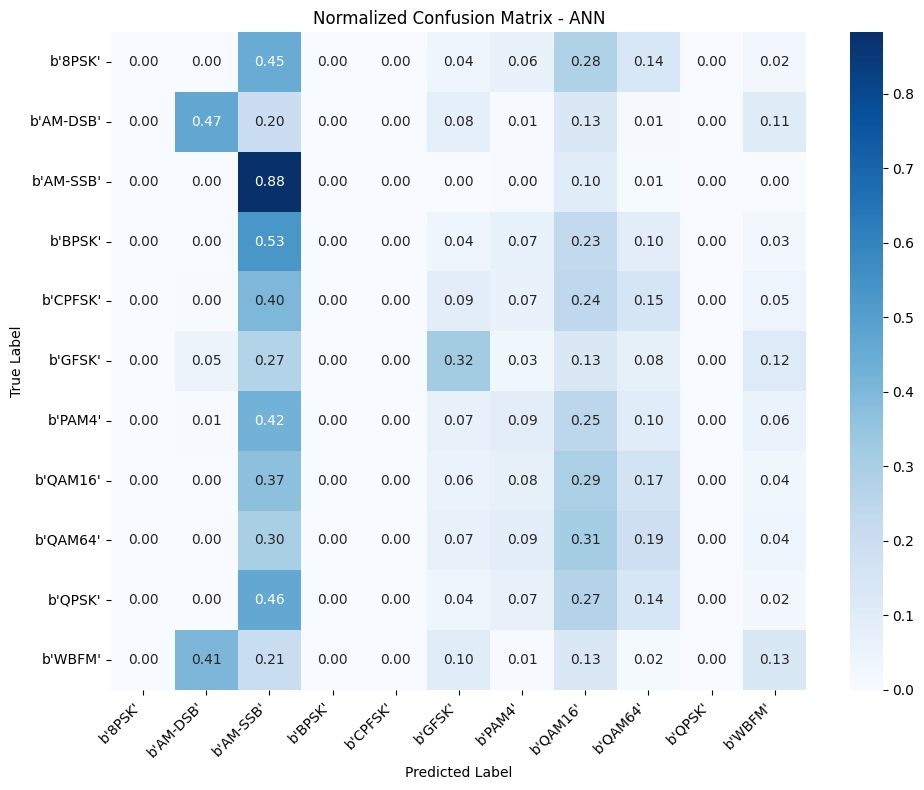

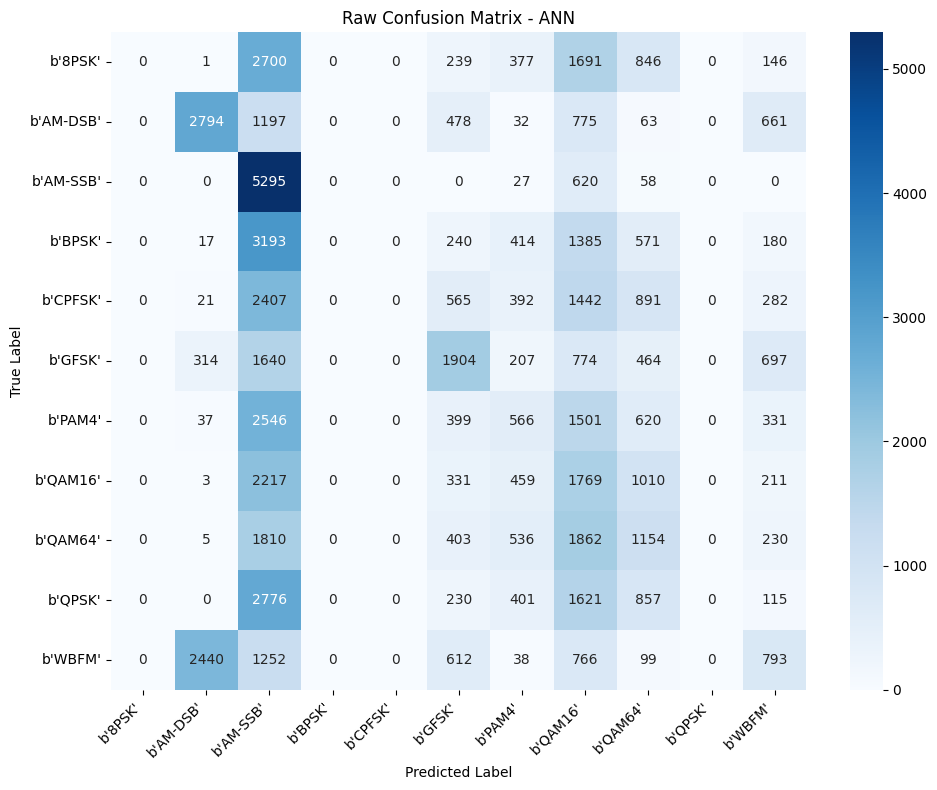

c:\Users\red pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


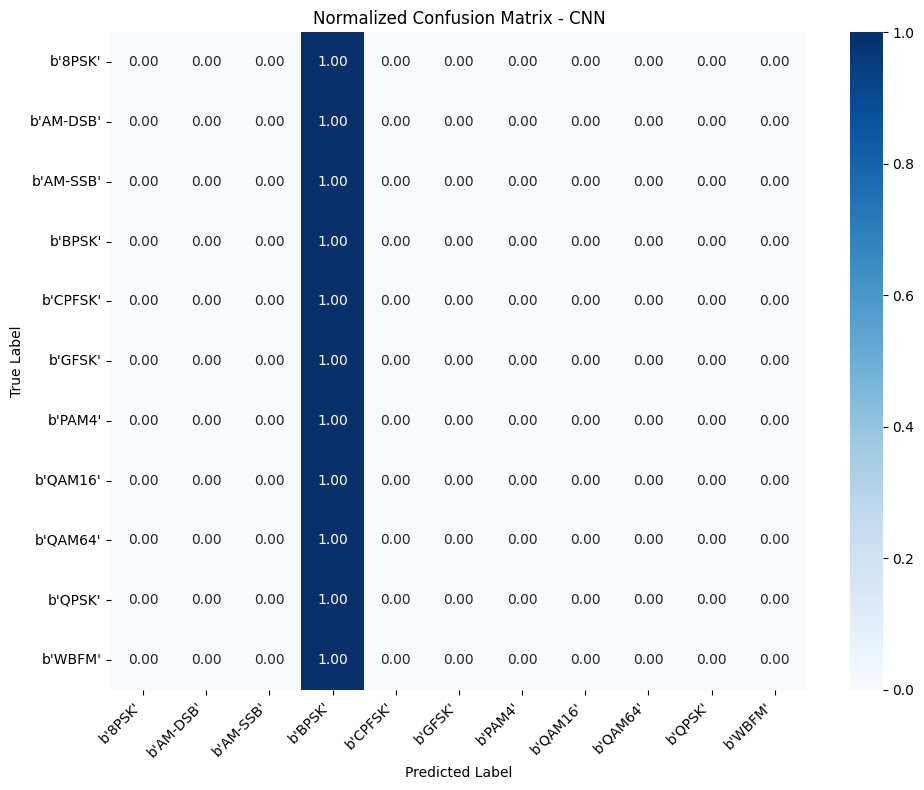

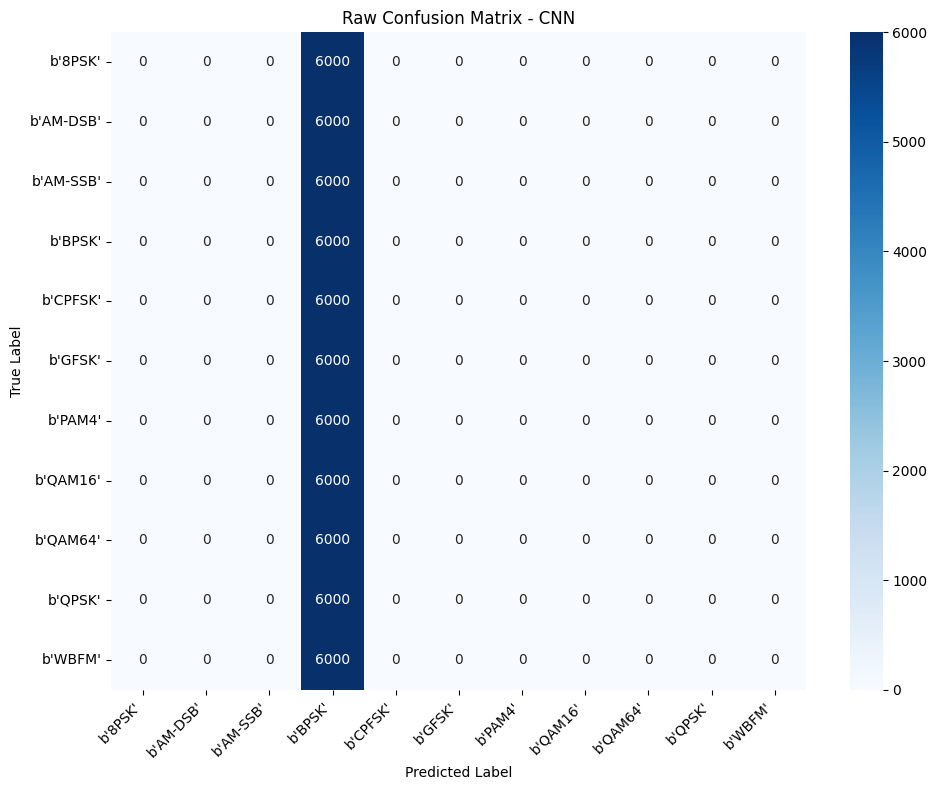


Model Performance Metrics:
                 ANN   CNN
Precision (%)  15.68  0.83
Recall (%)     21.63  9.09
F1-Score (%)   16.15  1.52

Accuracy per SNR:
      -20   -18   -16   -14    -12    -10    -8     -6     -4     -2      0   \
ANN  8.79  9.04  9.25  9.98  11.36  12.59  15.74  22.00  26.91  26.09  28.80   
CNN  8.85  9.71  9.46  8.15   8.60   9.58   9.34   9.32   9.08   9.10   9.34   

        2      4      6      8     10     12     14     16     18  
ANN  28.09  27.50  28.95  28.15  27.5  26.87  28.93  27.24  28.84  
CNN   9.24   9.04   8.74   8.49   8.9   9.26   9.32   9.17   9.11  


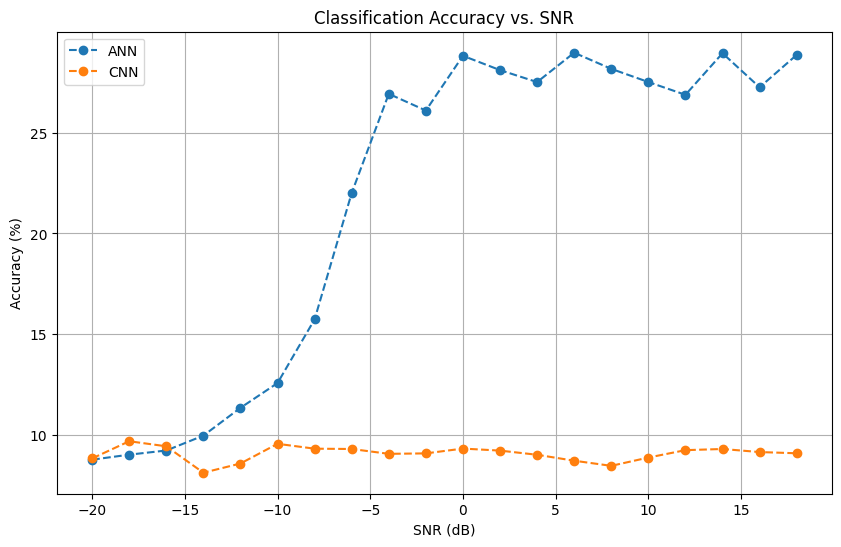

In [28]:
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

def evaluate_models(models, model_names, X_test, y_test, snr_test, test_loader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Store results for all models
    all_results = {}
    all_metrics = {}
    sorted_snrs = np.sort(np.unique(snr_test))
    
    for model, name in zip(models, model_names):
        model.to(device)
        model.eval()
        y_pred = []
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                y_pred.append(outputs.cpu().numpy())
        y_pred = np.concatenate(y_pred, axis=0)
        
        # Calculate accuracy per SNR
        results = []
        for snr in sorted_snrs:
            idx = np.where(snr_test == snr)
            acc = accuracy_score(np.argmax(y_test[idx], axis=1), 
                               np.argmax(y_pred[idx], axis=1))
            results.append(acc * 100)
        all_results[name] = results
        
        # Calculate precision, recall, F1-score
        y_true = np.argmax(y_test, axis=1)
        y_pred_classes = np.argmax(y_pred, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
        all_metrics[name] = {'precision': precision, 'recall': recall, 'f1': f1}
        
        # Plot confusion matrix (normalized and raw)
        cm = confusion_matrix(y_true, y_pred_classes)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Normalized confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.title(f'Normalized Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Raw confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=classes, yticklabels=classes)
        plt.title(f'Raw Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # Print metrics
    print("\nModel Performance Metrics:")
    metrics_df = df(data=[[all_metrics[name][metric] * 100 for name in model_names] 
                         for metric in ['precision', 'recall', 'f1']],
                   columns=model_names,
                   index=['Precision (%)', 'Recall (%)', 'F1-Score (%)']).round(2)
    print(metrics_df)
    
    # Print accuracy per SNR
    print("\nAccuracy per SNR:")
    accuracy_df = df(data=[all_results[name] for name in model_names],
                    columns=sorted_snrs,
                    index=model_names).round(2)
    print(accuracy_df)
    
    # Plot accuracy vs. SNR for all models
    plt.figure(figsize=(10, 6))
    for name in model_names:
        plt.plot(sorted_snrs, all_results[name], 'o--', label=name)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    plt.title('Classification Accuracy vs. SNR')
    plt.grid(True)
    plt.legend()
    plt.show()

# Evaluate both models
print("\nEvaluating both models...")
evaluate_models([ann_model, cnn_model], ['ANN', 'CNN'], X_test, y_test, snr_test, test_loader, mods)